In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

# Lab 5: Image Compression and Matrix Factorization

Matrix factorization is a way to find a set of basis vectors that describe a given dataset. Depending on the factorization used, the set of bases are different.

In this notebook, we use singular value decomposition (SVD) and nonnegative matrix factorization (NMF)

## Faces dataset

We use "[labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/)" dataset.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

img_count, img_height, img_width = lfw_people.images.shape
print('number of faces in dataset:', img_count)
print('image width in pixels     :', img_width)
print('image height in pixels    :', img_height)

number of faces in dataset: 1288
image width in pixels     : 37
image height in pixels    : 50


Each face is vectorized into a row in data matrix `X`

## Question 1a: Data transformation

Inspecting `lfw_people.images.shape` shows images are stored as a 3-dimensional array of size (1288, 50, 37). Use `numpy.ndarray.reshape()` to tranform matrix `lfw_people.images` to a 2-dimensional array of size `img_count` by `img_width` * `img_height` with name `X`. Take first image, `X[0]`, and `numpy.ndarray.reshape()` it back to a 2-dimensional array of size `img_img_height` by `img_width` with name `X0_img`. 

<!--
BEGIN QUESTION
name: q1a
manual: false
points: 3
-->

In [3]:
X = lfw_people.images.reshape(1288, 1850)
X0_img = X[0].reshape(50, 37)

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

If everything went correctly, you should see a gray scale image below

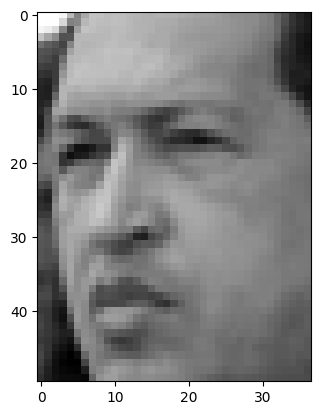

In [5]:
# each row of X is a vectorized image
plt.imshow(X0_img, cmap=plt.cm.gray);

<!-- BEGIN QUESTION -->

## Question 1b: Visualization

To make plotting easier, create a plotting function.

<!--
BEGIN QUESTION
name: q1b
manual: true
points: 3
-->

In [6]:
def draw_img(img_vector, h=img_height, w=img_width):

    plt.imshow(img_vector.reshape(img_height, img_width), cmap=plt.cm.gray)
    
    plt.xticks(())
    plt.yticks(())

<!-- END QUESTION -->



_Cell Intentionally Blank_

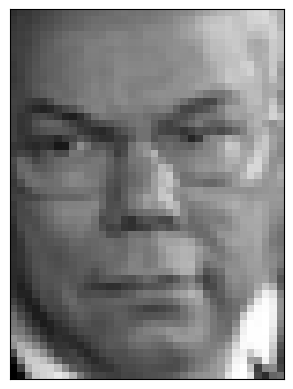

In [7]:
# check draw_img function
draw_img(X[49])

## Question 1c: Standardization

Since SVD looks for singular values (related to eigenvalues) and eigenvectors of `X`, center each column (pixel) of `X` so that mean of each column is zero. Otherwise the result can be strange. This is a detail that is not critical for understanding the conceptual aspect of SVD. The variance of each pixel can be left alone. Use [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardize `X` (hint: use `.fit_transform`).

<!--
BEGIN QUESTION
name: q1c
manual: false
points: 3
-->

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)
Xstd = scaler.fit_transform(X)

In [9]:
grader.check("q1c")

q1c results: All test cases passed!

The mean centered images look unnatural, but all the pertinent data is retained

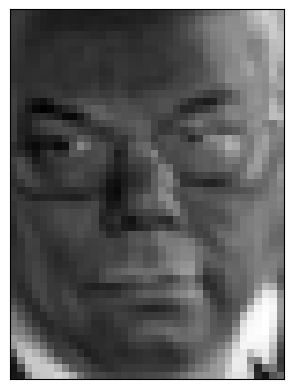

In [10]:
# standardization transforms image data
draw_img(Xstd[49])

### Inverse Transformation

We can recover the original data by putting the means back

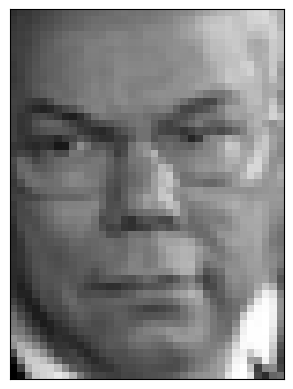

In [11]:
# inverse tranformation recovers original image units
Xorig = scaler.inverse_transform(Xstd)
draw_img(Xorig[49])

## Question 2a: Singular Value Decomposition (SVD)

Numpy package has SVD decomposition function [`numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html). Decompose `Xstd` into `U`, `S`, `VT`, i.e., $X_{std} = U S V^T$. Use `full_matrices=False`.



<!--
BEGIN QUESTION
name: q2a
manual: false
points: 3
-->

In [12]:
from numpy.linalg import svd

U, S, VT = np.linalg.svd(Xstd, full_matrices=False)

In [13]:
grader.check("q2a")

q2a results: All test cases passed!

## Question 2b: Matrix Factors from SVD

Since `S` is a diagonal matrix, multiplying `U` by `S` is like scaling each column of `U` by the corresponding diagonal entry. Check that we can recover the original data from the matrix factors by inverse transforming the resulting `Xhat`

<!--
BEGIN QUESTION
name: q2b
manual: false
points: 3
-->

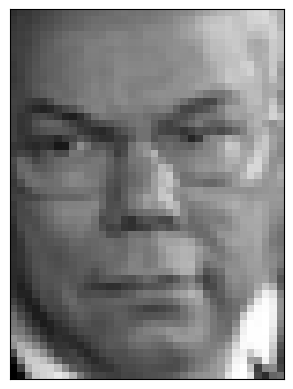

In [14]:
US = U*S

# reconstruct standardized images from matrix factors
Xhat = US.dot(VT)

# inverse transform Xhat to remove standardization
Xhat_orig = scaler.inverse_transform(Xhat)

draw_img(Xhat_orig[49])

In [15]:
grader.check("q2b")

q2b results: All test cases passed!

### Dimensionality reduction

We can describe each face using smaller portions of matrix factors. Because of how `US` and `VT` are ordered, the first portions of `US` and `VT` retain the most information. So, to keep the most relevant parts, keep the first columns of `US` and first rows of `VT`. Below illustrate why this is called a dimensionality reduction method.

In the following, we keep 500 columns of `US` and 500 rows of `VT` out of 1288.

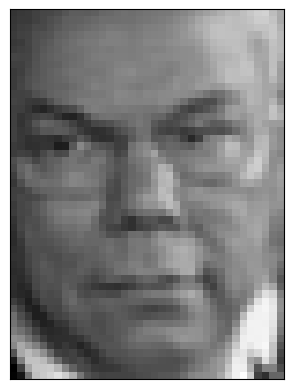

In [16]:
# reconstruct Xhat with less information: i.e. dimensionality is reduced
Xhat_500 = US[:, 0:500] @ VT[0:500, :]
# inverse transforms Xhat to remove standardization
Xhat_500_orig = scaler.inverse_transform(Xhat_500)
# draw recovered image
draw_img(Xhat_500_orig[49])

Using even smaller number degrades the reconstruction; however, still the reconstructed image captures the "gist" of the original data. 

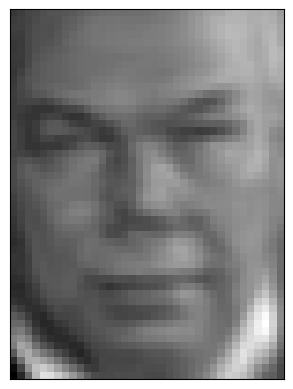

In [17]:
# reconstruct Xhat with less information: i.e. dimensionality is reduced
Xhat_100 = US[:, 0:100] @ VT[0:100, :]
# inverse transforms Xhat to remove standardization
Xhat_100_orig = scaler.inverse_transform(Xhat_100)
# draw recovered image
draw_img(Xhat_100_orig[49])

To make the dimensionality reduction and inverse transform easier, write a function:

In [18]:
def dim_reduce(US_, VT_, dim=100):
    
    Xhat_ = US_[:, 0:dim] @ VT_[0:dim, :]
    
    return scaler.inverse_transform(Xhat_)

We can see how the increasing the rows and columns of matrix factors used increases fidelity of reconstructions

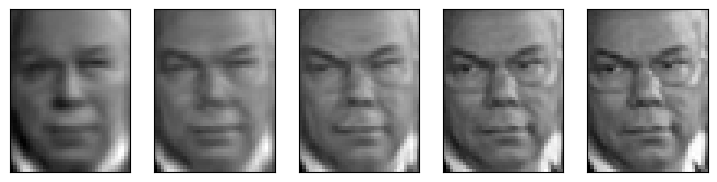

In [19]:
dim_vec = [50, 100, 200, 400, 800]

plt.figure(figsize=(1.8 * len(dim_vec), 2.4))

for i, d in enumerate(dim_vec):
    plt.subplot(1, len(dim_vec), i + 1)
    draw_img(dim_reduce(US, VT, d)[49])

### Matrix Factors and "Eigenfaces"

What are in these matrix factors `US` and `VT`?

`VT` contains the set of "basis" vectors. In this setting rows of `VT` are called eigenfaces

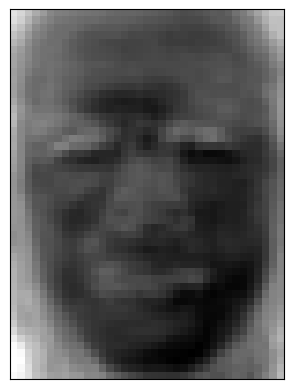

In [20]:
# each row of VT is an "eigenface"
draw_img(VT[0])

Plotting more eigenfaces show how the information in each eigenfaces are highlighting different components of photos

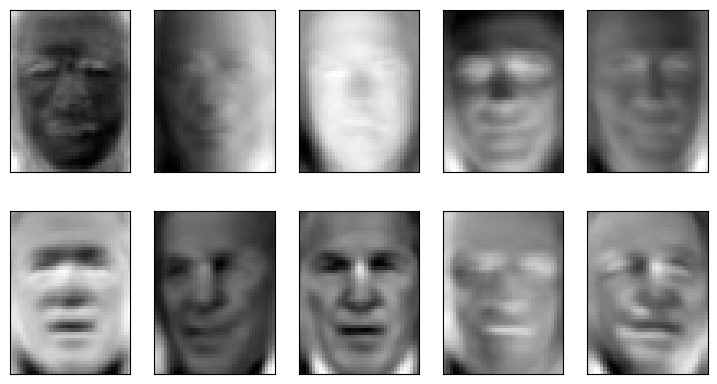

In [21]:
num_faces = 10
# each row of VT is an "eigenface"
plt.figure(figsize=(1.8 * 5, 2.4 * 2))

for i in range(0, 10):
    one_face = VT[i]
    plt.subplot(2, 5, i + 1)
    draw_img(one_face)

### Each face is a linear combination of eigenfaces

Reconstructing a face can be thought of as combining these eigenfaces according to some row of `US` (coefficients). 

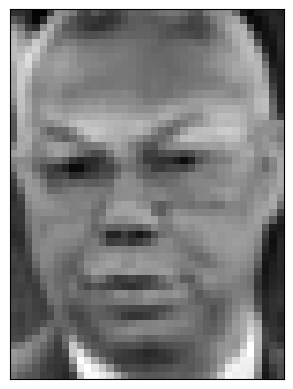

In [22]:
# each face is a linear combination of eigenfaces VT

face_num = 3 # which face to reconstruct?
dim = 300    # higher dim is more accurate fit
draw_img((US[face_num, 0:dim] @ VT[:dim,:]))

## Question 3: Nonnegative Matrix Factorization

NMF is a matrix factorization method that require nonnegative data matrix. Images are represented as light intensities between 0 and 255: i.e. nonnegative numbers.

NMF decomposes `X` into `W` and `H` such that $X \approx WH$. NMF is slower than SVD. So, we only choose a very small number of basis here: 200. Obtain `W` and `H`. Use [`sklearn.decomposition.NMF`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

*Warning*: This process will take a few minutes to complete and will not converge to the optimal solution. After passing the test, you are encouraged to play around with the number of components and increasing the max_iter parameter and comparing the results.

<!--
BEGIN QUESTION
name: q3
manual: false
points: 3
-->

In [23]:
from sklearn.decomposition import NMF
model = NMF(n_components=200, init='nndsvd', random_state=0)
W = model.fit_transform(X)
H = model.components_

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [24]:
grader.check("q3")

q3 results: All test cases passed!

### Matrix factor H

NMF matrix factor `H` contain the set of basis faces.

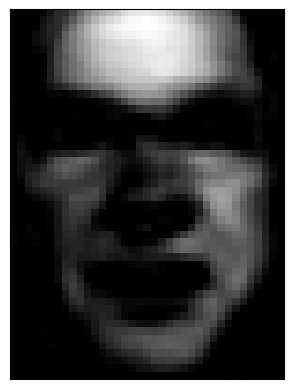

In [25]:
draw_img(H[0])

Following shows that the set of basis vectors are very different than what SVD chose

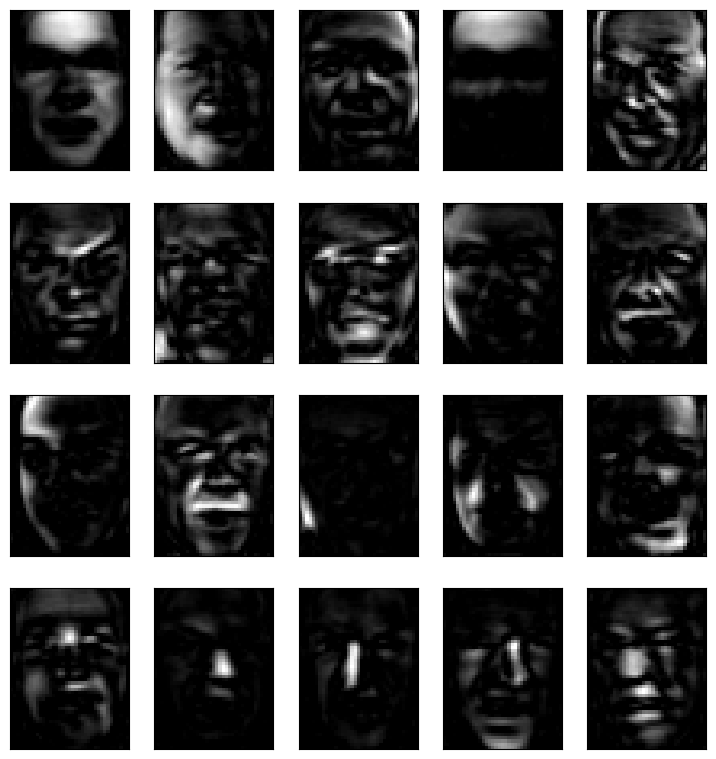

In [26]:
num_faces = 20
plt.figure(figsize=(1.8 * 5, 2.4 * 4))

for i in range(0, num_faces):
    one_face = VT[i]
    plt.subplot(4, 5, i + 1)
    draw_img(H[i])

However, each face is still a linear combination of matrix `H`

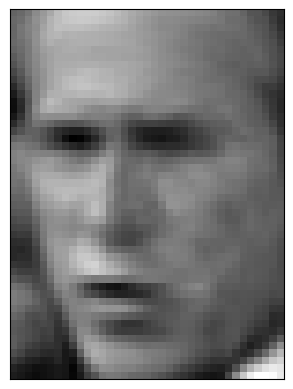

In [27]:
draw_img(W[30]@H) # using 200 NMF basis vectors

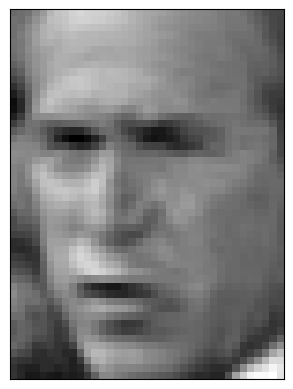

In [28]:
draw_img(dim_reduce(US, VT, 200)[30]) # using 200 SVD basis vectors

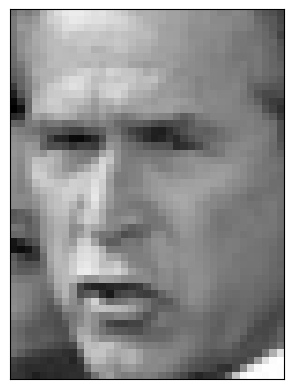

In [29]:
draw_img(X[30]) # original image 

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [30]:
grader.check_all()

q1a results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()